# COMP-5011 Course Project - Model Training

## Heart Failure Prediction Using Machine Learning: A Binary Classification Approach


**Sainzolboo Anujin** - 1311002

**Syed Abdul Rahman** – 1260544

**Tao Xue** - 1316845


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu
from scipy.stats import mannwhitneyu
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    roc_curve,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

In [14]:
def print_scores(tag, y_true, y_pred):
    """Helper to print accuracy and F1."""
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"{tag} - accuracy: {acc:.4f}, f1: {f1:.4f}")

def make_pipeline_with_rf(**rf_kwargs):
    rf = RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        **rf_kwargs,
    )
    pipe = Pipeline(
        steps=[
            ("model", rf),
        ]
    )
    return pipe

In [15]:
df = pd.read_csv("heart_cleaned.csv")
display(df.head())


# Mapping for categorical columns
mapping_dict = {
    "Sex": {"M": 1, "F": 0},
    "ExerciseAngina": {"Y": 1, "N": 0},
    "ChestPainType": {"ATA": 0, "NAP": 1, "ASY": 2, "TA": 3},
    "RestingECG": {"Normal": 0, "ST": 1, "LVH": 2},
    "ST_Slope": {"Up": 0, "Flat": 1, "Down": 2}
}

# Apply mapping
for col, mapping in mapping_dict.items():
    df[col] = df[col].map(mapping)

print("\nAfter Mapping:")
display(df.head())

# Separating target and features
target_col = "HeartDisease"
X = df.drop(columns=[target_col])
y = df[target_col]


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0



After Mapping:


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,0,140,289,0,0,172,0,0.0,0,0
1,49,0,1,160,180,0,0,156,0,1.0,1,1
2,37,1,0,130,283,0,1,98,0,0.0,0,0
3,48,0,2,138,214,0,0,108,1,1.5,1,1
4,54,1,1,150,195,0,0,122,0,0.0,0,0


### Train / test split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,  # binary classification, using stratify to keep the ratio
)

### Decision Tree baseline

In [36]:
dt = DecisionTreeClassifier(
    random_state=42,  
)
dt_pipe = Pipeline(
    steps=[
        ("model", dt),
    ]
)

dt_pipe.fit(X_train, y_train)
y_pred_dt = dt_pipe.predict(X_test)
print_scores("Decision Tree baseline (test)", y_test, y_pred_dt)

# calculate cv：
dt_cv = cross_val_score(
    dt_pipe, X_train, y_train, cv=5, scoring="f1", n_jobs=-1
)
print(f"Decision Tree baseline CV F1 mean: {dt_cv.mean():.6f}")

Decision Tree baseline (test) - accuracy: 0.8152, f1: 0.8265
Decision Tree baseline CV F1 mean: 0.808462


### Gradient Boosting baseline

In [37]:
gbdt = GradientBoostingClassifier(
    random_state=42
)

gbdt_pipe = Pipeline(
    steps=[
        # ("preprocess", preprocess),
        ("model", gbdt),
    ]
)

# Train and evaluate on test set
gbdt_pipe.fit(X_train, y_train)
y_pred_gbdt = gbdt_pipe.predict(X_test)
print_scores("GBDT baseline (test)", y_test, y_pred_gbdt)

# Cross-validation performance
gbdt_cv = cross_val_score(
    gbdt_pipe, X_train, y_train, cv=5, scoring="f1", n_jobs=-1
)
print(f"GBDT baseline CV F1 mean: {gbdt_cv.mean():.6f}")

GBDT baseline (test) - accuracy: 0.8804, f1: 0.8932
GBDT baseline CV F1 mean: 0.865798


## Step 1: Baseline model

In [39]:
baseline_params = {
    "n_estimators": 200,   # start with a bigger one
    # default with other parameters
}
baseline_pipe = make_pipeline_with_rf(**baseline_params)
baseline_pipe.fit(X_train, y_train)
y_pred_baseline = baseline_pipe.predict(X_test)
print_scores("Baseline", y_test, y_pred_baseline)
cv_baseline = cross_val_score(baseline_pipe, X_train, y_train, cv=5, scoring="f1")
print("Baseline CV F1 mean:", cv_baseline.mean())

Baseline - accuracy: 0.8804, f1: 0.8922
Baseline CV F1 mean: 0.8702428643899539


## Step 2: Tune max_depth & min_samples_leaf

In [46]:
step2_pipe = baseline_pipe

param_grid_step2 = {
    "model__max_depth": [5, 10, None],
    "model__min_samples_leaf": [1, 2, 4],
}

grid_step2 = GridSearchCV(
    estimator=step2_pipe,
    param_grid=param_grid_step2,
    cv=5,
    scoring="f1",
    n_jobs=-1,
)
grid_step2.fit(X_train, y_train)

print("Best params (Step 2):", grid_step2.best_params_)
print("Best CV f1  (Step 2):", grid_step2.best_score_)

best_max_depth = grid_step2.best_params_["model__max_depth"]
best_min_samples_leaf = grid_step2.best_params_["model__min_samples_leaf"]

Best params (Step 2): {'model__max_depth': 5, 'model__min_samples_leaf': 1}
Best CV f1  (Step 2): 0.877682761084633


## Step 3: Tune n_estimators

In [47]:
# based on best step2 parameters, adjust the tree numbers
step3_pipe = make_pipeline_with_rf(
    max_depth=best_max_depth,
    min_samples_leaf=best_min_samples_leaf,
)

param_grid_step3 = {
    "model__n_estimators": [100, 300, 500],
}

grid_step3 = GridSearchCV(
    estimator=step3_pipe,
    param_grid=param_grid_step3,
    cv=5,
    scoring="f1",
    n_jobs=-1,
)
grid_step3.fit(X_train, y_train)

print("Best params (Step 3):", grid_step3.best_params_)
print("Best CV f1  (Step 3):", grid_step3.best_score_)

best_n_estimators = grid_step3.best_params_["model__n_estimators"]

Best params (Step 3): {'model__n_estimators': 300}
Best CV f1  (Step 3): 0.8800457639354405


## Step 4: Tune max_features

In [48]:
# based on the latter steps, adjust the max_features
step4_pipe = make_pipeline_with_rf(
    max_depth=best_max_depth,
    min_samples_leaf=best_min_samples_leaf,
    n_estimators=best_n_estimators,
)

param_grid_step4 = {
    "model__max_features": ["sqrt", 0.5],  # sqrt classic，0.5
}

grid_step4 = GridSearchCV(
    estimator=step4_pipe,
    param_grid=param_grid_step4,
    cv=5,
    scoring="f1",
    n_jobs=-1,
)
grid_step4.fit(X_train, y_train)

print("Best params (Step 4):", grid_step4.best_params_)
print("Best CV f1  (Step 4):", grid_step4.best_score_)

best_max_features = grid_step4.best_params_["model__max_features"]

Best params (Step 4): {'model__max_features': 'sqrt'}
Best CV f1  (Step 4): 0.8800457639354405


## Step 5: min_samples_split & bootstrap

In [50]:
step5_pipe = make_pipeline_with_rf(
    max_depth=best_max_depth,
    min_samples_leaf=best_min_samples_leaf,
    n_estimators=best_n_estimators,
    max_features=best_max_features,
)

param_grid_step5 = {
    "model__min_samples_split": [2, 5, 10],
    "model__bootstrap": [True, False],
}

grid_step5 = GridSearchCV(
    estimator=step5_pipe,
    param_grid=param_grid_step5,
    cv=5,
    scoring="f1",
    n_jobs=-1,
)
grid_step5.fit(X_train, y_train)

print("Best params (Step 5):", grid_step5.best_params_)
print("Best CV f1  (Step 5):", grid_step5.best_score_)

best_min_samples_split = grid_step5.best_params_["model__min_samples_split"]
best_bootstrap = grid_step5.best_params_["model__bootstrap"]

Best params (Step 5): {'model__bootstrap': True, 'model__min_samples_split': 2}
Best CV f1  (Step 5): 0.8800457639354405


## Step 6: Joint fine-tuning around Step 5 best params

In [51]:
# max_depth
if best_max_depth is None:
    max_depth_candidates = [None, 10, 15]
else:
    lower = max(3, best_max_depth - 2)
    upper = best_max_depth + 2
    max_depth_candidates = sorted(set([lower, best_max_depth, upper]))

# n_estimators
n_min = max(50, best_n_estimators - 100)
n_max = best_n_estimators + 100
n_estimators_candidates = sorted(set([n_min, best_n_estimators, n_max]))

# min_samples_leaf
leaf_candidates = sorted(set([best_min_samples_leaf,
                                max(1, best_min_samples_leaf - 1)]))

# max_features
if best_max_features == "sqrt":
    max_features_candidates = ["sqrt", 0.5]
else:
    max_features_candidates = [best_max_features, "sqrt"]

# min_samples_split
split_candidates = sorted(set([best_min_samples_split, 2, 5, 10]))

# bootstrap
bootstrap_candidates = [True, False]

print("Joint search candidate space:")
print("  n_estimators:", n_estimators_candidates)
print("  max_depth:", max_depth_candidates)
print("  min_samples_leaf:", leaf_candidates)
print("  max_features:", max_features_candidates)
print("  min_samples_split:", split_candidates)
print("  bootstrap:", bootstrap_candidates)

step6_pipe = make_pipeline_with_rf()

param_grid_step6 = {
    "model__n_estimators": n_estimators_candidates,
    "model__max_depth": max_depth_candidates,
    "model__min_samples_leaf": leaf_candidates,
    "model__max_features": max_features_candidates,
    "model__min_samples_split": split_candidates,
    "model__bootstrap": bootstrap_candidates,
}

grid_step6 = GridSearchCV(
    estimator=step6_pipe,
    param_grid=param_grid_step6,
    cv=5,
    scoring="f1",
    n_jobs=-1,
)
grid_step6.fit(X_train, y_train)

print("Best params (Step 6 - joint):", grid_step6.best_params_)
print("Best CV f1  (Step 6 - joint):", grid_step6.best_score_)
best_cv_step6 = grid_step6.best_score_

print(f"\nCompare Step5 vs Step6 CV F1:")
print(f"  Step 5 best CV F1: {grid_step5.best_score_:.6f}")
print(f"  Step 6 best CV F1: {best_cv_step6:.6f}")

best_params_step6 = grid_step6.best_params_

Joint search candidate space:
  n_estimators: [200, 300, 400]
  max_depth: [3, 5, 7]
  min_samples_leaf: [1]
  max_features: ['sqrt', 0.5]
  min_samples_split: [2, 5, 10]
  bootstrap: [True, False]
Best params (Step 6 - joint): {'model__bootstrap': False, 'model__max_depth': 5, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best CV f1 (Step 6 - joint): 0.8807882359240666

Compare Step5 vs Step6 CV F1:
  Step 5 best CV F1: 0.880046
  Step 6 best CV F1: 0.880788


## Step 6: Final RF model (Step 6 best) evaluation on test set

In [52]:
final_pipe = make_pipeline_with_rf(
    n_estimators=best_params_step6["model__n_estimators"],
    max_depth=best_params_step6["model__max_depth"],
    min_samples_leaf=best_params_step6["model__min_samples_leaf"],
    max_features=best_params_step6["model__max_features"],
    min_samples_split=best_params_step6["model__min_samples_split"],
    bootstrap=best_params_step6["model__bootstrap"],
)

final_pipe.fit(X_train, y_train)
y_pred_final = final_pipe.predict(X_test)
print_scores("RF Final (Step 6 best, test)", y_test, y_pred_final)
print("\nRF Final (Step 6) classification report:\n")
print(classification_report(y_test, y_pred_final))

RF Final (Step 6 best, test) - accuracy: 0.8750, f1: 0.8889

RF Final (Step 6) classification report:

              precision    recall  f1-score   support

           0       0.87      0.84      0.86        82
           1       0.88      0.90      0.89       102

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.88      0.87       184



## Confusion Matrix


Confusion matrix (RF Final):
 [[69 13]
 [10 92]]


<Figure size 640x480 with 0 Axes>

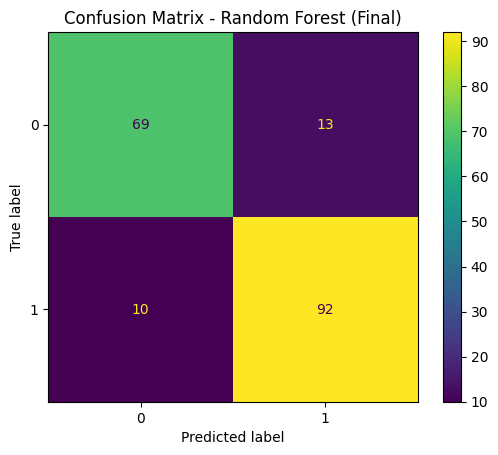

In [53]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
print("\nConfusion matrix (RF Final):\n", cm)

plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(values_format="d")
plt.title("Confusion Matrix - Random Forest (Final)")
plt.show()

## Feature Importance


Top 15 feature importances (RF Final):
           feature  importance
10        ST_Slope    0.373592
2    ChestPainType    0.178995
8   ExerciseAngina    0.116310
9          Oldpeak    0.097925
7            MaxHR    0.075605
1              Sex    0.035345
5        FastingBS    0.034605
4      Cholesterol    0.032540
0              Age    0.030455
3        RestingBP    0.017778
6       RestingECG    0.006850


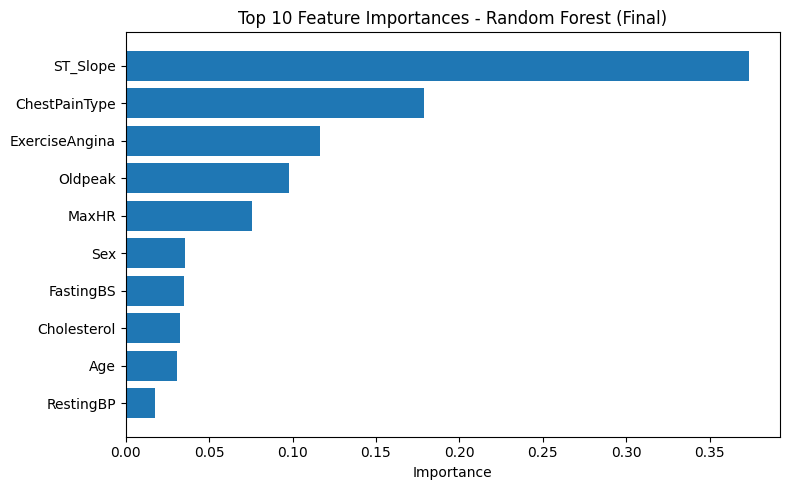

In [56]:
rf_final = final_pipe.named_steps["model"]

# feature names
feature_names = np.array(X_train.columns)

importances = rf_final.feature_importances_

#  sorted DataFrame
fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances,
}).sort_values("importance", ascending=False)

print("\nTop 15 feature importances (RF Final):")
print(fi_df.head(15))

# plot
top_k = 10
top_fi = fi_df.head(top_k)
plt.figure(figsize=(8, 5))
plt.barh(top_fi["feature"][::-1], top_fi["importance"][::-1])
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances - Random Forest (Final)")
plt.tight_layout()
plt.show()

## ROC curve


RF Final ROC-AUC: 0.9296


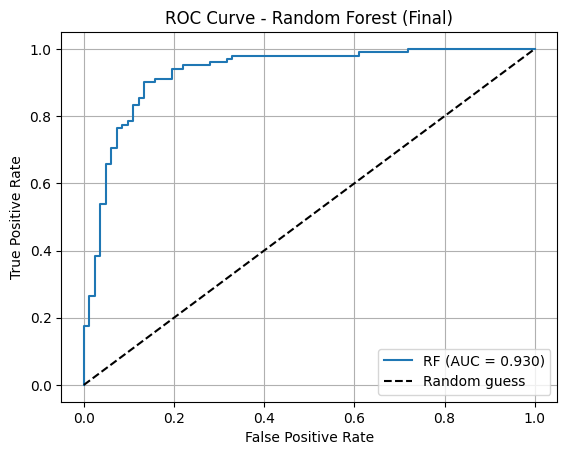

In [55]:
y_proba_final = final_pipe.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba_final)
auc = roc_auc_score(y_test, y_proba_final)
print(f"\nRF Final ROC-AUC: {auc:.4f}")

plt.figure()
plt.plot(fpr, tpr, label=f"RF (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest (Final)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()